### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [4]:
#train_dataset = tf.keras.preprocessing.image_dataset_from_directory('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
#                                                                        validation_split=0.2,
#                                                                        subset="training",
#                                                                        shuffle=False,
#                                                                        image_size=(224,224),
#                                                                        batch_size=32,
#                                                                        )

train_dataset  = train_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [5]:
#valid_dataset = tf.keras.preprocessing.image_dataset_from_directory('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
#                                                                        validation_split=0.2,
#                                                                        subset="validation",
#                                                                        shuffle=False,
#                                                                        image_size=(224,224),
#                                                                        batch_size=32,
#                                                                        )
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [6]:
#test_dataset = tf.keras.preprocessing.image_dataset_from_directory("../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test",
##                                                            shuffle=False,
#                                                            image_size=(224,224),
#                                                            batch_size=32,
#)

test_dataset = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1279 images belonging to 4 classes.


## feature preprocessing and label encoding.

### MODEL BUILDING

In [7]:
os.path.exists('D:\sem 7\weights\densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5')

False

In [8]:
from tensorflow.keras.applications import DenseNet121

# Define the local path to the downloaded weights file
weights_path ='/kaggle/input/weights/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load the model with the local weights file
base_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights=weights_path)


In [9]:
##base_model = DenseNet121(input_shape=(224,224,3), 
  ##                 include_top=False,
    ##               weights="imagenet")

In [10]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [11]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels

    def build(self, input_shape):
        self.theta = Conv2D(self.channels // 8, (1, 1), strides=(1, 1), padding='same')
        self.phi = Conv2D(self.channels // 8, (1, 1), strides=(1, 1), padding='same')
        self.g = Conv2D(self.channels // 2, (1, 1), strides=(1, 1), padding='same')
        self.o = Conv2D(self.channels, (1, 1), strides=(1, 1), padding='same')

    def call(self, inputs):
        theta = self.theta(inputs)
        phi = self.phi(inputs)
        g = self.g(inputs)

        theta = tf.reshape(theta, [-1, theta.shape[1] * theta.shape[2], theta.shape[3]])
        phi = tf.reshape(phi, [-1, phi.shape[1] * phi.shape[2], phi.shape[3]])
        g = tf.reshape(g, [-1, g.shape[1] * g.shape[2], g.shape[3]])

        attn = tf.nn.softmax(tf.matmul(theta, phi, transpose_b=True))
        attn_g = tf.matmul(attn, g)

        attn_g = tf.reshape(attn_g, [-1, inputs.shape[1], inputs.shape[2], g.shape[-1]])
        o = self.o(attn_g)

        x = inputs + o
        return x


In [12]:
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,MaxPooling2D, BatchNormalization, Dropout, Activation
import tensorflow as tf

model = Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    SelfAttention(64),  # Add SelfAttention layer
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
     Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
     Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Change to the appropriate number of classes
])

In [13]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          294944    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
self_attention (SelfAttentio (None, 3, 3, 64)          5232      
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               73856     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [14]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [15]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [16]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [18]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 3,
                        verbose = 1,
                         callbacks=lr_scheduler)

Epoch 1/3
129/129 [==============================] - 496s 4s/step - loss: 33.5887 - accuracy: 0.7396 - precision: 0.4544 - recall: 0.2064 - auc: 0.7329 - f1_score: 0.2691 - val_loss: 1.0349 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7804 - val_f1_score: 0.0000e+00
Epoch 2/3
129/129 [==============================] - 502s 4s/step - loss: 1.1613 - accuracy: 0.7474 - precision: 0.4861 - recall: 0.1796 - auc: 0.7748 - f1_score: 0.2324 - val_loss: 1.0351 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7804 - val_f1_score: 0.0000e+00
Epoch 3/3
129/129 [==============================] - 485s 4s/step - loss: 1.0527 - accuracy: 0.7491 - precision: 0.4959 - recall: 0.2060 - auc: 0.7765 - f1_score: 0.2711 - val_loss: 1.0346 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7804 - val_f1_score: 0.0000e+00


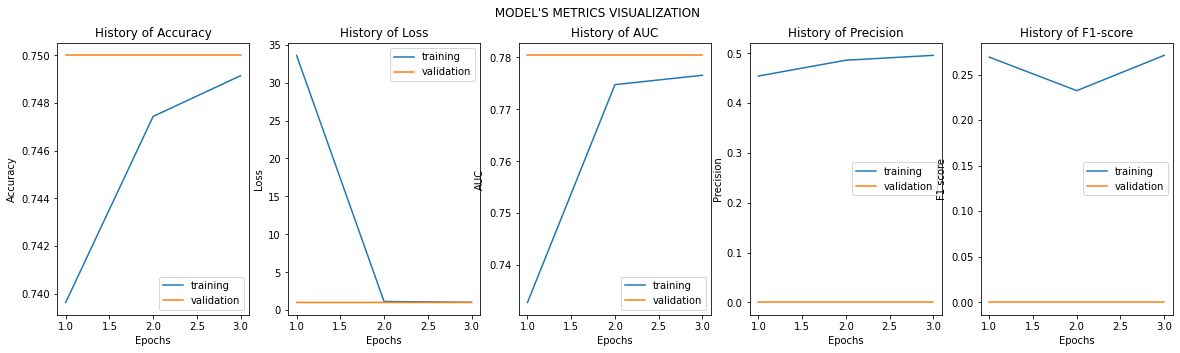

In [19]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [20]:
scores = model.evaluate_generator(test_dataset)

In [21]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.75
Precision =  0.0
Recall =  0.0
AUC =  0.7805577516555786
F1_score =  0.0
